배달앱 데이터

출처 : 데이콘 포스트 코로나 데이터 시각화 경진대회 (<https://www.dacon.io/competitions/official/235618/overview/>)

## 필요한 모듈 import

In [1]:
# 함수 관련
import numpy as np
import pandas as pd
from IPython.display import Image

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
# 그래프 관련
import matplotlib.pyplot as plt
import plotly.express as px

import plotly.io as pio
pio.renderers.default = "notebook_connected"

import plotly.graph_objs as go

import plotly.offline as pyo
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)

In [3]:
import plotly
from plotly import tools

In [4]:
# 폰트 설정
import os
plt.rcParams['font.family'] = 'AppleGothic'

## 데이터 불러오기

### 데이터 큰 전처리

In [5]:
delivery = pd.read_csv("delivery.csv")

> 사용할 데이터 열
 - PROCESS_DT : 처리일시
 - DLVR_STORE_ID : 배달상점ID
 - DLVR_RCEPT_CMPNY_ID : 배달접수회사ID
 - DLVR_STORE_INDUTY_NM : 배달상점 업종이름
 - DLVR_STORE_SIDO : 배달상점 주소 시도명
 - DLVR_STORE_SIGUNGU : 배달상점 주소 시군구명
 - DLVR_DSTN_SIDO : 배달목적지 주소 법정동 시도명
 - GOODS_AMOUNT : 배달상품금액
 - SETLE_KND_VALUE : 결제종류번호 (1:카드, 2:선불, 3:현금)
 - DLVR_RCEPT_TIME : 배달접수시간

In [9]:
# 우리가 사용할 컬럼 추출
col = ["PROCESS_DT", "DLVR_STORE_ID", "DLVR_RCEPT_CMPNY_ID","DLVR_STORE_INDUTY_NM",
       "DLVR_STORE_SIDO","DLVR_STORE_SIGUNGU","DLVR_DSTN_SIDO","GOODS_AMOUNT",
       "SETLE_KND_VALUE","DLVR_RCEPT_TIME"]
del_df = delivery.loc[:,col]

### 날짜 및 시간 전처리

In [10]:
# 날짜 타입 변경 및 년도, 월 열 추가하기
del_df["PROCESS_DT"] = pd.to_datetime(del_df["PROCESS_DT"], format='%Y-%m-%d')
del_df['year'] = pd.DatetimeIndex(del_df['PROCESS_DT']).year
del_df['month'] = pd.DatetimeIndex(del_df['PROCESS_DT']).month

In [11]:
del_df["PROCESS_DT"]

0         2020-01-01
1         2020-01-01
2         2020-01-01
3         2020-01-01
4         2020-01-01
             ...    
5158319   2020-06-21
5158320   2020-06-21
5158321   2020-06-21
5158322   2020-06-21
5158323   2020-06-21
Name: PROCESS_DT, Length: 5158324, dtype: datetime64[ns]

배달앱의 데이터는 2020-01-01 부터 2020-06-21의 데이터를 담고 있음

## 데이터 분석

### 배달 산업 현황 분석

포스트 코로나의 언택트 문화 확산으로 인해 배달 산업의 성장이 예상됨

#### 배달 건수에 대한 분석

In [12]:
# 날짜별 총 배달 건수 합
del_date = del_df.groupby("PROCESS_DT").size().reset_index(name="count")

# datetime형으로 변환해주기
del_date["PROCESS_DT"] = pd.to_datetime(del_date["PROCESS_DT"], format = '%Y-%m-%d')

In [13]:
# 월별 건수를 보자면
del_month = del_df.groupby("month").size().reset_index(name="count")
del_month

,month,count
0,1,824058
1,2,895861
2,3,971131
3,4,967309
4,5,1023593
5,6,476372


1월부터 5월까지 늘어가는 추세를 파악할 수 있다.

6월의 경우 마지막 1주 이상이 제외되었기 때문에, 불균형하다고 판단됨

In [14]:
# 일별 배달 건수 그래프
ax1 = go.Scatter(
    x = del_date["PROCESS_DT"],
    y = del_date['count'],
    name = "일별 배달 건수",
    mode = "lines",
    marker = dict(size=3, line=dict(width=10), color="darkgreen")
)

# 월별 배달 건수 그래프
ax2 = go.Scatter(
    x = del_month.loc[0:4,"month"],
    y = del_month.loc[0:4,'count'],
    name = "월별 배달 건수",
    mode = "lines",
    marker = dict(size=3, line=dict(width=10), color="navy")
)

# subplot
fig = tools.make_subplots(rows=2, cols=1, print_grid=False,
                      subplot_titles=("일별 배달 건수 변화", "월별 배달 건수 변화"))
fig.append_trace(ax1, 1, 1)
fig.append_trace(ax2, 2, 1)


# 그래프 설명들 추가해주기
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_xaxes(title_text="Month", row=2, col=1)
fig.update_yaxes(title_text="배달 건수")

# 전체적인 layout
fig["layout"].update(height=800, width = 800, title = "Date/Month 별 배달 건수 변화 그래프")

plotly.offline.iplot(fig)

/Users/yeonsu/opt/anaconda3/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



일/월 모두 코로나가 시작된 1월 말 / 2월 초 부터 **상승곡선의 형태**를 보여주고 있음

    - 1월 26에 갑작스런 하락세는 설날(공휴일)이기 때문

(불완전 데이터인 6월 합계 배달 건수 제외)

따라서 이후에도 배달 건수는 많아질 것으로 예측하며, **Prophet을 통해 배달 건수를 예측**해보고자 한다

#### 배달 건수에 대한 예측

In [15]:
# 페이스북에서 제공하는 Prophet 라이브러리 사용
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

In [16]:
# 예측이 가능하도록 Dataframe col 이름 변형해 만들어주기
forecast_df = del_date.rename(columns = {"PROCESS_DT":"ds", "count":"y"})
forecast_df

,ds,y
0,2020-01-01,30853
1,2020-01-02,21838
2,2020-01-03,25928
3,2020-01-04,30015
4,2020-01-05,31234
...,...,...
160,2020-06-10,34133
161,2020-06-11,31344
162,2020-06-12,36273
163,2020-06-20,41880


In [23]:
# 원래 우리가 가지고 있는 데이터 fit 시켜주기
prop = Prophet(n_changepoints=2, weekly_seasonality=True, growth="logistic")
forecast_df["cap"] = 50000
prop.fit(forecast_df) 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [24]:
# 현재 데이터 이후 8월까지의 배달 건수를 예측을 위해 71일 추가
aug = prop.make_future_dataframe(periods=71)
aug["cap"] = 50000

In [25]:
# 8월까지 예측
to_aug = prop.predict(aug)
to_aug

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,27161.375841,50000,19924.202280,28516.247154,27161.375841,27161.375841,-2994.426914,-2994.426914,-2994.426914,-2994.426914,-2994.426914,-2994.426914,0.0,0.0,0.0,24166.948927
1,2020-01-02,27212.263405,50000,19777.175526,28343.056499,27212.263405,27212.263405,-3059.952157,-3059.952157,-3059.952157,-3059.952157,-3059.952157,-3059.952157,0.0,0.0,0.0,24152.311248
2,2020-01-03,27263.132499,50000,24331.539235,32885.187889,27263.132499,27263.132499,1193.615603,1193.615603,1193.615603,1193.615603,1193.615603,1193.615603,0.0,0.0,0.0,28456.748103
3,2020-01-04,27313.982706,50000,28532.709457,37122.354561,27313.982706,27313.982706,5483.224778,5483.224778,5483.224778,5483.224778,5483.224778,5483.224778,0.0,0.0,0.0,32797.207483
4,2020-01-05,27364.813607,50000,29463.637263,38383.759862,27364.813607,27364.813607,6459.638096,6459.638096,6459.638096,6459.638096,6459.638096,6459.638096,0.0,0.0,0.0,33824.451704
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,2020-08-27,38010.356601,50000,30854.729847,39427.379466,38010.356548,38010.356651,-3059.952157,-3059.952157,-3059.952157,-3059.952157,-3059.952157,-3059.952157,0.0,0.0,0.0,34950.404443
232,2020-08-28,38047.708424,50000,35319.832559,43688.796219,38047.708370,38047.708476,1193.615603,1193.615603,1193.615603,1193.615603,1193.615603,1193.615603,0.0,0.0,0.0,39241.324027
233,2020-08-29,38084.980361,50000,39488.951226,47800.578607,38084.980305,38084.980414,5483.224778,5483.224778,5483.224778,5483.224778,5483.224778,5483.224778,0.0,0.0,0.0,43568.205138
234,2020-08-30,38122.172353,50000,40229.580526,49158.368546,38122.172295,38122.172408,6459.638096,6459.638096,6459.638096,6459.638096,6459.638096,6459.638096,0.0,0.0,0.0,44581.810449


[ 일별 배달 건수 시각화 및 8월까지의 배달 건수 예측 ]


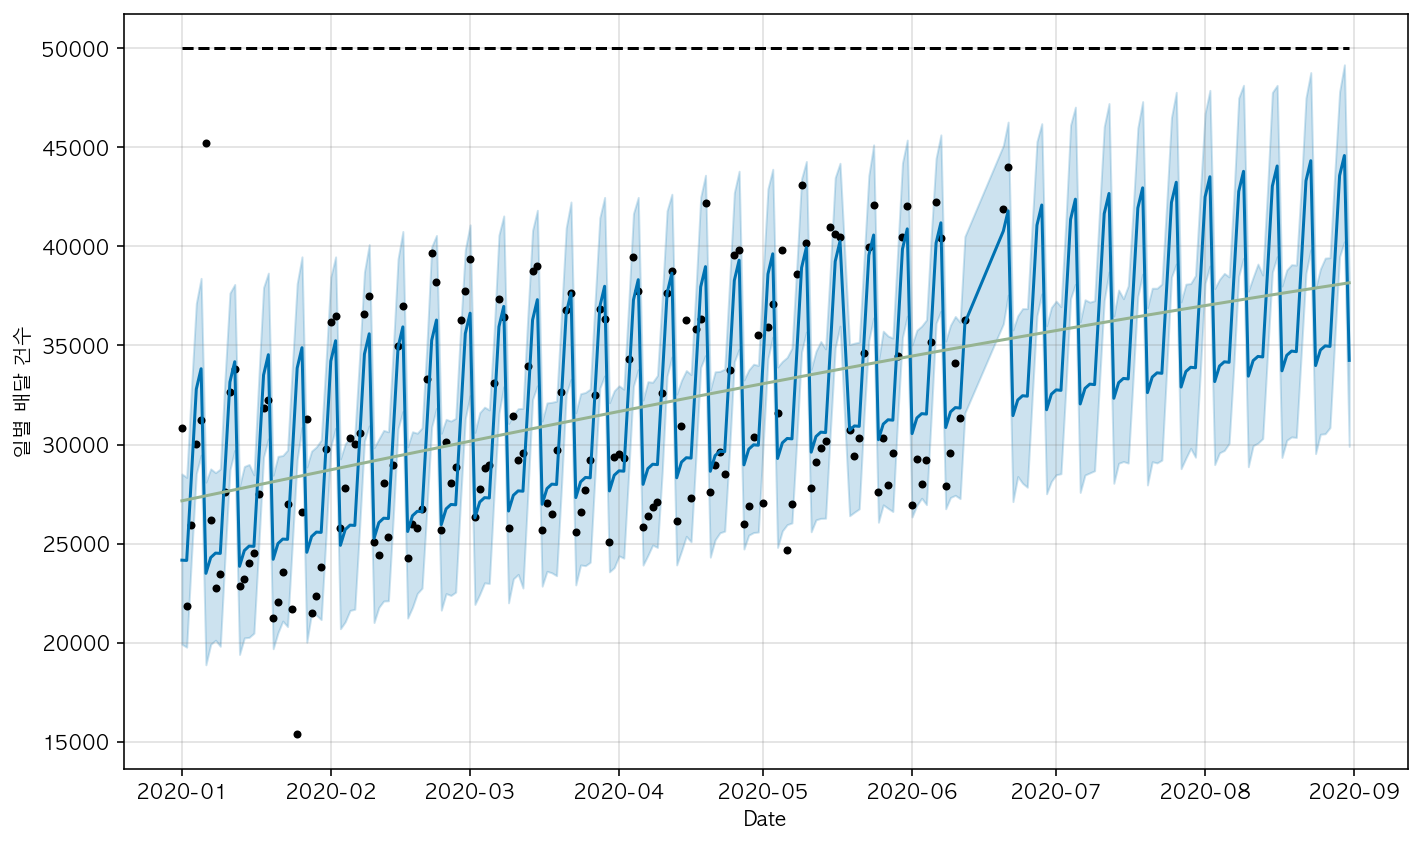

In [26]:
# 예측한 것 그래프로 나타내기
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

fig1 = prop.plot(to_aug, xlabel="Date", ylabel="일별 배달 건수")
graph = add_changepoints_to_plot(fig1.gca(), prop, to_aug, cp_color="#95b391")

print("[ 일별 배달 건수 시각화 및 8월까지의 배달 건수 예측 ]")

In [27]:
prop.changepoints

66    2020-03-07
131   2020-05-11
Name: ds, dtype: datetime64[ns]

#### 파라미터 튜닝한 예측

In [28]:
holidays = pd.DataFrame({
    'holiday' : 'new years day',
    'ds': pd.to_datetime('2020-02-27'),
    'lower_window':0,
    'upper_window':1}, index=['auto'])

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[ 일별 배달 건수 시각화 및 8월까지의 배달 건수 예측 ]


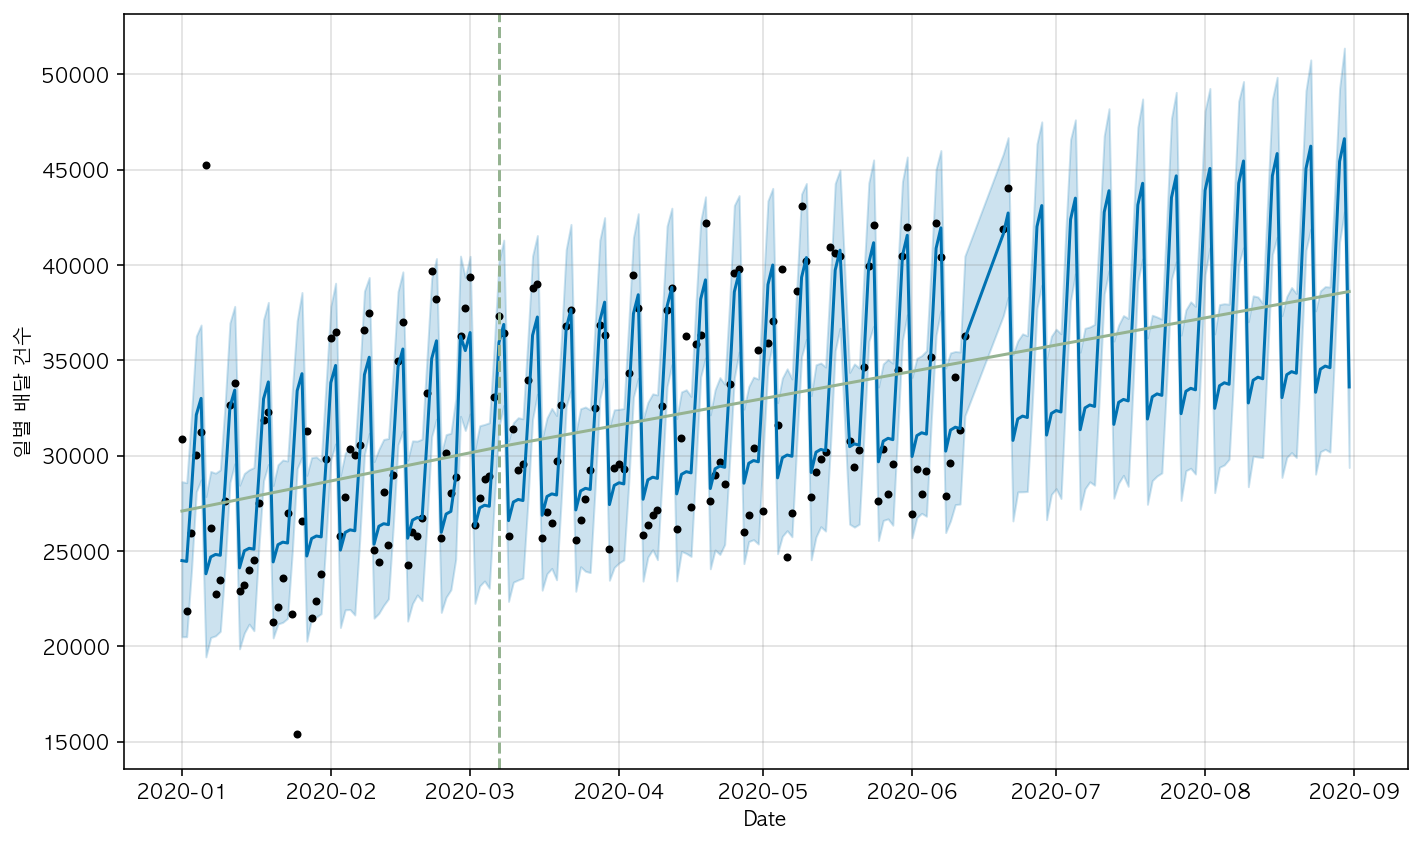

In [82]:
prop = Prophet(seasonality_mode = "multiplicative", 
               weekly_seasonality=True, n_changepoints=2,
              holidays = holidays)
prop.fit(forecast_df)
aug = prop.make_future_dataframe(periods=71)
to_aug = prop.predict(aug)
fig1 = prop.plot(to_aug, xlabel="Date", ylabel="일별 배달 건수")
graph = add_changepoints_to_plot(fig1.gca(), prop, to_aug, cp_color="#95b391")
print("[ 일별 배달 건수 시각화 및 8월까지의 배달 건수 예측 ]")

In [83]:
prop.changepoints

66    2020-03-07
131   2020-05-11
Name: ds, dtype: datetime64[ns]

In [22]:
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False

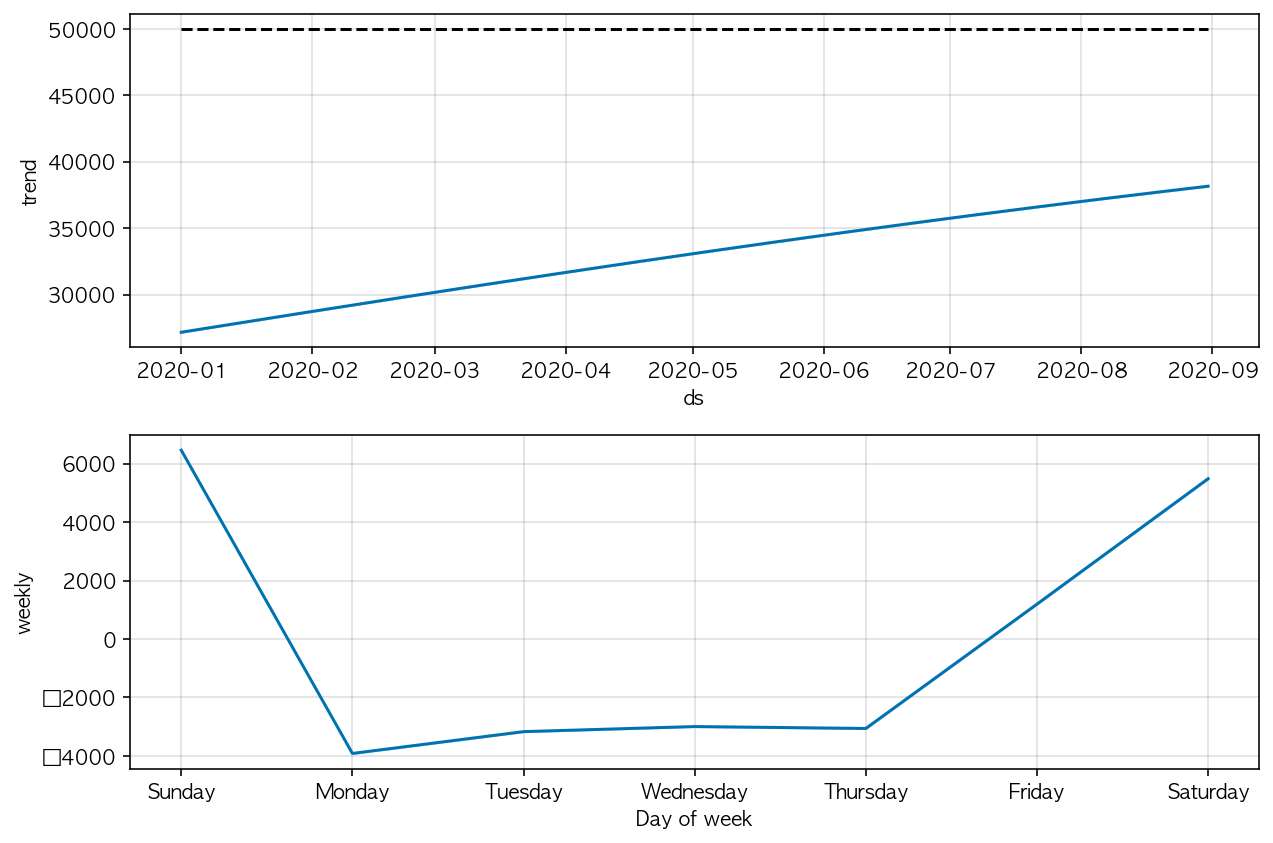

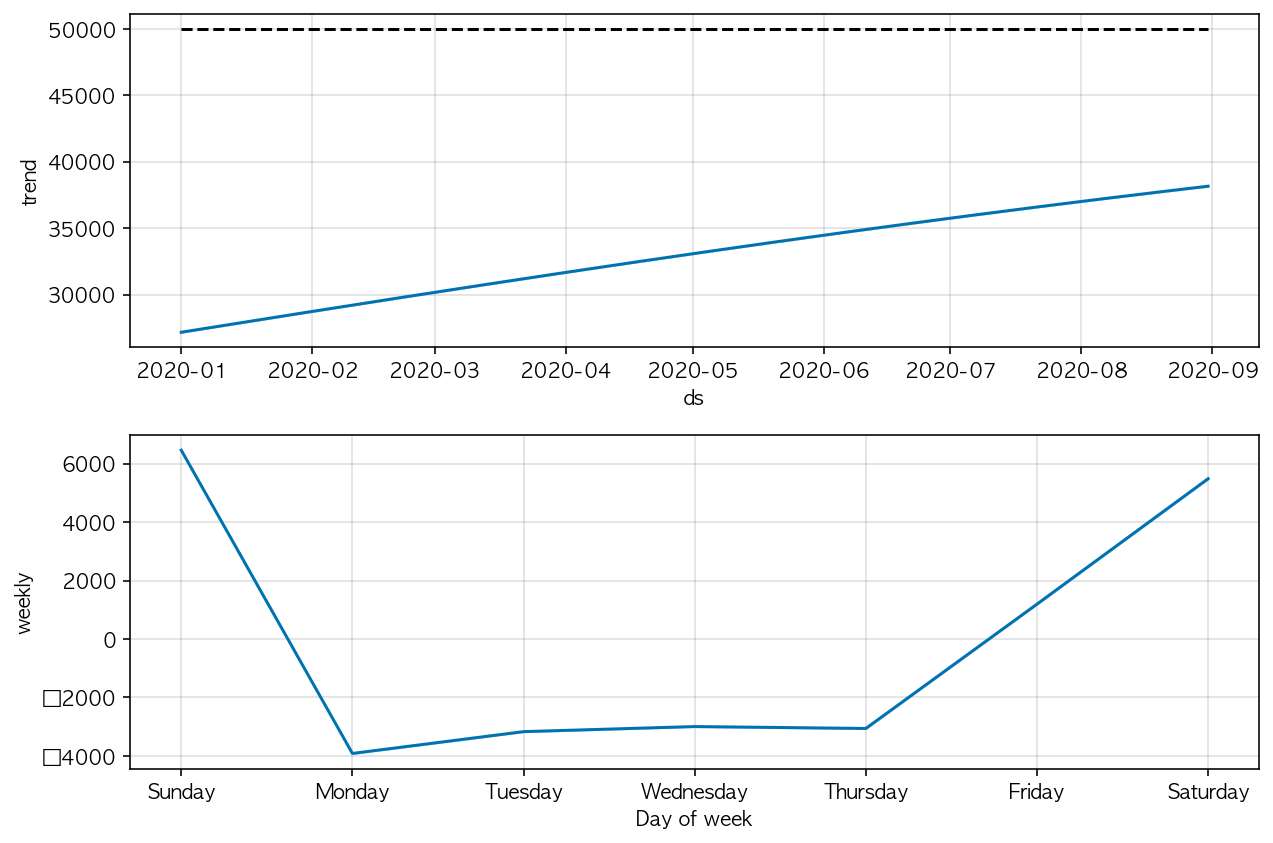

In [30]:
prop.plot_components(to_aug)

- 배달 건수가 뚜렷하게 상승하고 있으며, 이후 8월까지도 상승할 것으로 예측이 되는 바이다.
- 1달에 4번 간격으로 업다운이 있는 것은 주 단위로 반복되는 추세로 파악된다.

- 월별 소비량으로 보아도 (코로나 지속시) 배달 수요는 꾸준히 증가할 것으로 예상할 수 있음
- 평균적으로 가장 낮은 배달량을 보이는 것은 월요일 / 주말의 배달량이 굉장히 높은 편

#### 배달 시간대별 분석

> 시간대 분류 기준
- 오전 : 5시 - 11시
- 점심 : 11시 - 5시
- 저녁 : 17시 - 23시
- 야식 : 23시 - 5시

In [24]:
# 배달 접수 시간의 Hour을 뽑기
del_df["DLVR_RCEPT_TIME"] = pd.to_datetime(del_df["DLVR_RCEPT_TIME"])
del_df["hour"] = pd.DatetimeIndex(del_df["DLVR_RCEPT_TIME"]).hour

In [25]:
del_df.hour.unique()

array([ 0,  1, 10, 11,  2,  9,  3,  4,  8,  6,  7,  5, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [26]:
# 시간대별 분류해 오전/점심/저녁/새벽 구분해주기

am = del_df.query('5<=hour<11').index
lunch = del_df.query('11<=hour<17').index
dinner = del_df.query('17<=hour<23').index
night = del_df.query("23<=hour<24 or 0<=hour<5").index

del_df["시간대"] = 0
del_df.loc[am, "시간대"] = '오전'
del_df.loc[lunch, "시간대"] = '점심'
del_df.loc[dinner, "시간대"] = '저녁'
del_df.loc[night, "시간대"] = '야식'

In [27]:
del_df.groupby("시간대").size().reset_index(name="count").sort_values(by="count")

,시간대,count
1,오전,97093
0,야식,323439
3,점심,1669496
2,저녁,3068296


- 배달 건수로 보자면, 저녁 > 점심 > 야식 > 오전 순서
- 절대량은 아직 저녁이 가장 우세

월별로 시간대 별 배달 건수에 변화가 있는지 살펴보자

In [28]:
# 시간대별 df 생성해주기
del_am = del_df.loc[am]
del_lunch = del_df.loc[lunch]
del_dinner = del_df.loc[dinner]
del_night = del_df.loc[night]

In [29]:
# 시간대별 배달 건수 집계해주기
del_am = del_am.groupby("month", as_index=False).size().reset_index(name="count")
del_lunch = del_lunch.groupby("month", as_index=False).size().reset_index(name="count")
del_dinner = del_dinner.groupby("month", as_index=False).size().reset_index(name="count")
del_night = del_night.groupby("month", as_index=False).size().reset_index(name="count")

In [30]:
del_am

,month,count
0,1,12511
1,2,15273
2,3,17522
3,4,19791
4,5,21885
5,6,10111


In [27]:
# 1월 대비 5월의 증감량

timezones = [del_am, del_lunch, del_dinner, del_night]
times = ["아침", "점심", "저녁", "야식"]
i=1

print("1월 대비 5월의 배달 건수 시간대별 증감량")
print(" ")
print("===============================")

for time, timezone in zip(times, timezones):
    change = (timezone.loc[4,"count"] - timezone.loc[0,"count"])/timezone.loc[0,"count"]*100
    print("{0}) {1} 증감량 : {2}".format(i, time, change))
    i += 1

print("===============================")

1월 대비 5월의 배달 건수 시간대별 증감량
 
1) 아침 증감량 : 74.92606506274478
2) 점심 증감량 : 32.66166071868318
3) 저녁 증감량 : 20.785760361232057
4) 야식 증감량 : 5.850296790636842


1월 대비 배달 건수 시간대별 증감량 그래프

In [39]:
def make_per_df(data=None):
    data["percentage"] = round(data["count"]/data["count"][0] *100,2)
    data.drop(index=5, axis=0, inplace = True)

In [40]:
# 비율로 변환한 데이터 프레임 생성
datas = [del_am, del_lunch, del_dinner, del_night]

for data in datas:
    make_per_df(data)

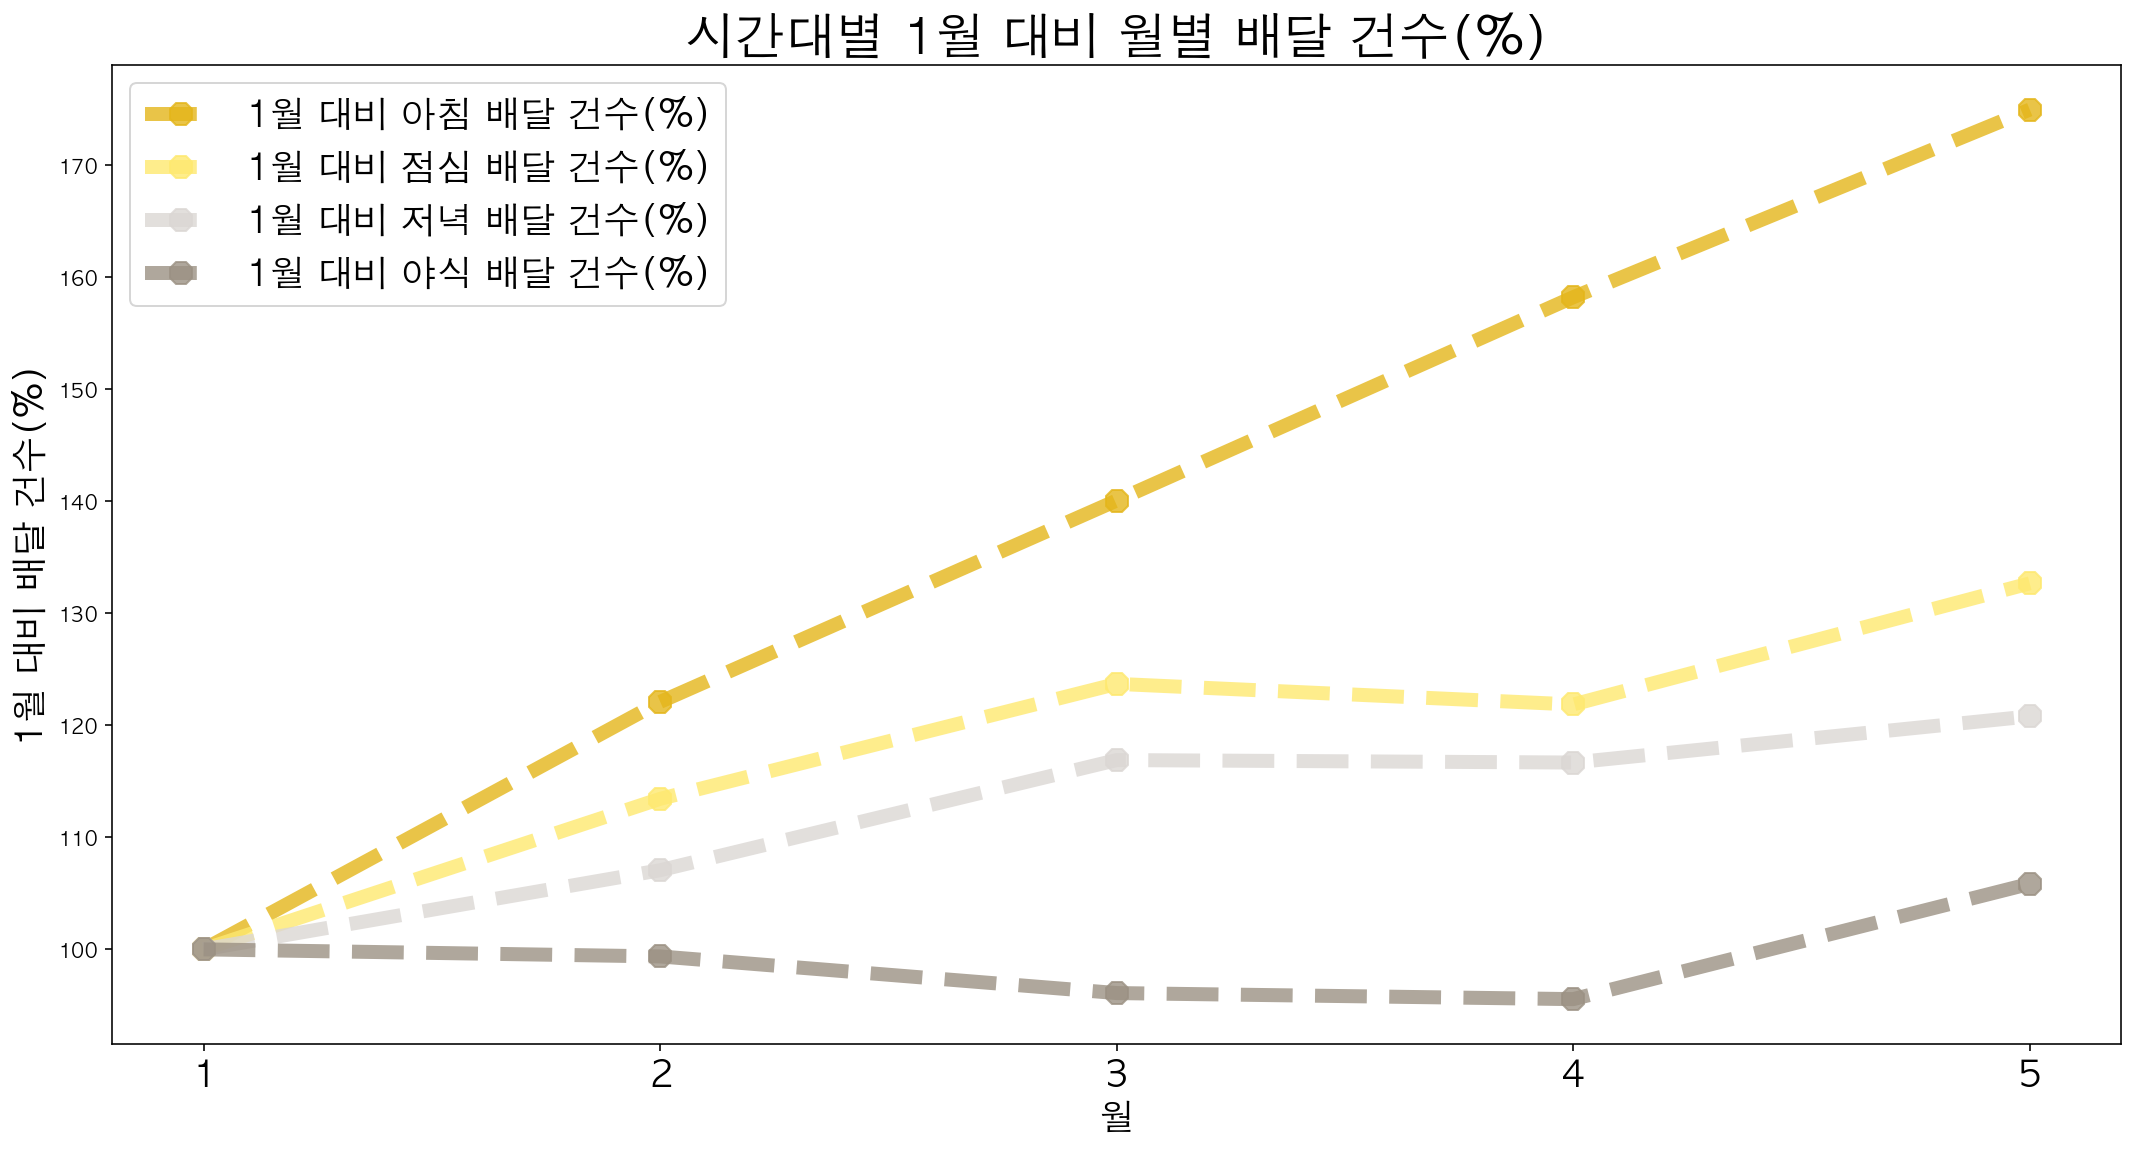

In [46]:
# 전년 대비 증감률 월별 변화량 그래프
plt.figure(figsize=(18,9))

plt.plot(del_am.month, del_am.percentage, color="#e4b61a", linestyle="--", marker="8", 
         linewidth=7.0, markersize=12, label="1월 대비 아침 배달 건수(%)", alpha=0.8)
plt.plot(del_lunch.month, del_lunch.percentage, color="#fee970", linestyle="--", marker="8", 
         linewidth=7.0, markersize=12, label="1월 대비 점심 배달 건수(%)", alpha=0.8)
plt.plot(del_dinner.month, del_dinner.percentage, color="#dbd7d4", linestyle="--", marker="8", 
         linewidth=7.0, markersize=12, label="1월 대비 저녁 배달 건수(%)", alpha=0.8)
plt.plot(del_night.month, del_night.percentage, color="#9b9183", linestyle="--", marker="8", 
         linewidth=7.0, markersize=12, label="1월 대비 야식 배달 건수(%)", alpha=0.8)


plt.xticks(del_am.month, fontsize=18)
plt.title("시간대별 1월 대비 월별 배달 건수(%)", fontsize=25)
plt.xlabel("월", fontsize=18)
plt.ylabel("1월 대비 배달 건수(%)", fontsize=18)
plt.legend(loc="upper left", fontsize=18)
plt.savefig("시간대별 1월 대비 월별 배달 건수.png", boox_inches='tight')

plt.show()

- 한가지 주목 할 만한 사실

절대적인 양 크기와는 별개로 증감량의 경우 1월(코로나 이전) 대비 5월(코로나 이후)

=> 아침 > 점심 > 저녁 > 야식 순서로 많이 증가하였음을 알 수 있다

이는 평소 배달음식이라는 인식이 저녁과 야식에 집중되어있었던 반면

코로나로 인한 언택트 문화와 재택근무 등 새로운 일상이 시작되면서 배달의 아침과 점심의 수요가 많이 늘어가게 된 것으로 파악되는 바이다.

    따라서 배달 건수가 증가한 이유에는 배달 산업 자체의 확장 (코로나 이전에도 배달 산업은 성장하고 있었으므로)도 있지만, 코로나로 인한 뉴노멀의 현상이 지배적이라는 것이라고 주장하는 바이다.

#### 배달 서비스 점포 수 분석

그렇다면 배달 건수가 늘은 만큼 배달 서비스를 제공하고자 하는 점포들의 수도 증가하였을까?

In [48]:
# 배달 호출을 한 업체가 하루에 몇 개
del_store = del_df.groupby("PROCESS_DT")["DLVR_STORE_ID"].nunique().reset_index(name="num_of_stores")
del_store

,PROCESS_DT,num_of_stores
0,2020-01-01,2365
1,2020-01-02,2618
2,2020-01-03,2727
3,2020-01-04,2793
4,2020-01-05,2550
...,...,...
160,2020-06-10,3496
161,2020-06-11,3332
162,2020-06-12,3468
163,2020-06-20,3523


In [49]:
fig = px.line(del_store, x = "PROCESS_DT", y = "num_of_stores")
fig.update_layout(
    title = {
        "text" : "일별 배달 서비스 제공 점포 수"
    }
)
fig.show()

- 설날인 1월 25일을 제외하고는 배달 서비스 제공 업체 수 역시 일정 주기를 가지고 증가하는 추세를 보인다

#### 배달 서비스 점포 수 예측

In [50]:
# prophet 사용할 수 있게 데이터 프레임 재설정
now_store = del_store.rename(columns = {"PROCESS_DT" : "ds", "num_of_stores" : "y"})

In [51]:
prop = Prophet(growth="linear")
prop.fit(now_store)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [52]:
# 미래 상점 개수 데이터 프레임 모양 생성
future_store = prop.make_future_dataframe(periods = 71)
future_store

,ds
0,2020-01-01
1,2020-01-02
2,2020-01-03
3,2020-01-04
4,2020-01-05
...,...
231,2020-08-27
232,2020-08-28
233,2020-08-29
234,2020-08-30


In [53]:
# 배달 서비스 제공 상점 수 예측
forecast_store = prop.predict(future_store)

8월까지의 배달 서비스 제공 점포 수 예측


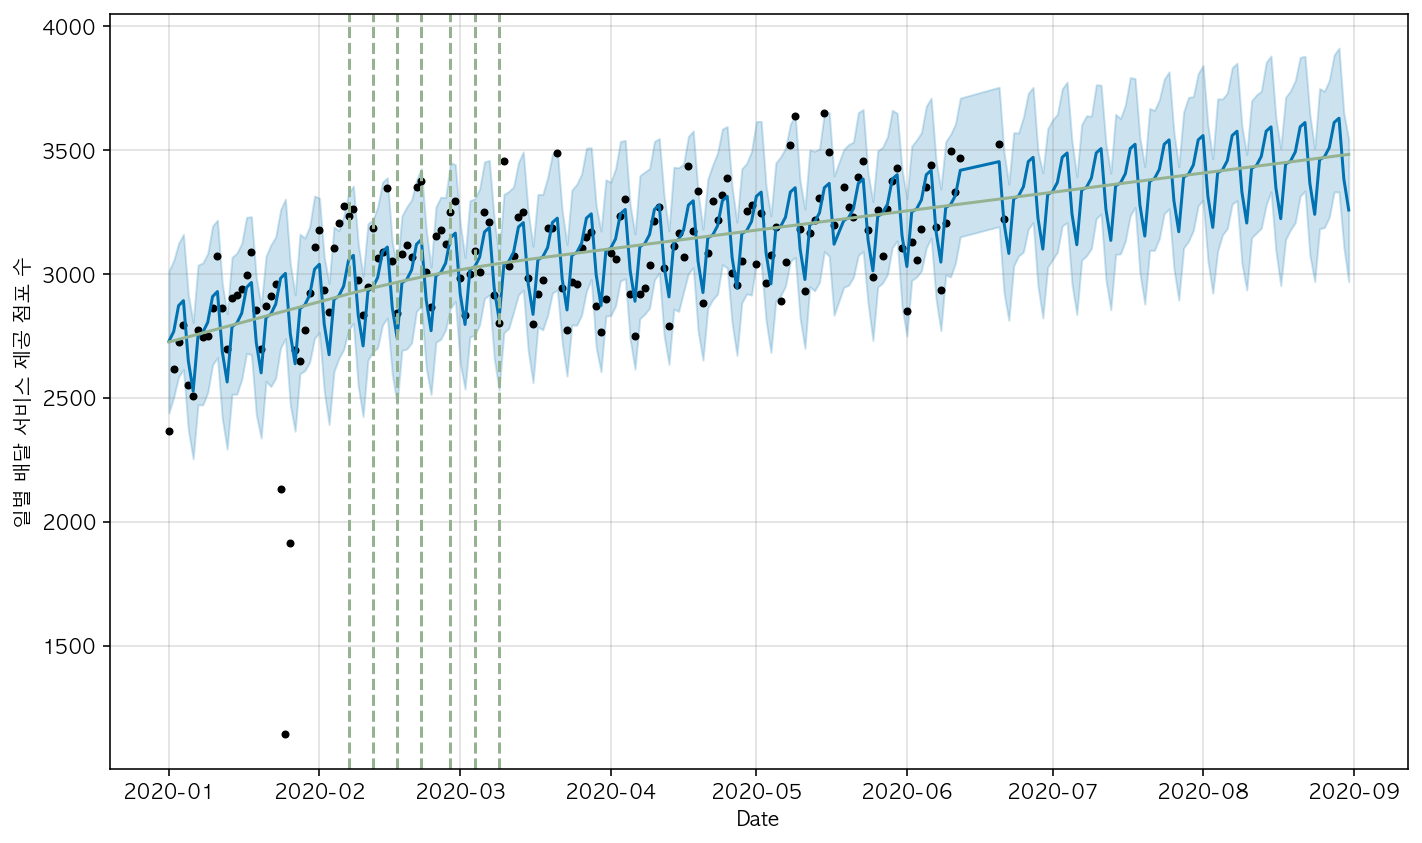

In [54]:
fig = prop.plot(forecast_store, xlabel="Date", ylabel="일별 배달 서비스 제공 점포 수")
ax8 = add_changepoints_to_plot(fig.gca(), prop, forecast_store, cp_color="#95b391")
print("8월까지의 배달 서비스 제공 점포 수 예측")

- 역시 예상대로 배달 서비스 제공 점포도 계속 증가 추세를 보인다

#### 배달 결제 방식 분석

결제 수단의 변화 역시 포스트 코로나 시대의 바뀐 소비 습관을 알아볼 수 있는 중요한 지표라고 생각한다.

현금의 경우, 실물 화폐가 필요하고 대면 결제가 필수이다.

카드의 경우 디지털을 사용하기는 하나 직접 접촉이 필요하다.

반면, 선불 결제의 경우 휴대폰과 같은 비대면 결제 방식이 가능하다.

In [45]:
del_pay = del_df.groupby(["PROCESS_DT", "SETLE_KND_VALUE"]).size().reset_index(name="count")
del_pay

,PROCESS_DT,SETLE_KND_VALUE,count
0,2020-01-01,1,9220
1,2020-01-01,2,18419
2,2020-01-01,3,3214
3,2020-01-02,1,6438
4,2020-01-02,2,12614
...,...,...,...
490,2020-06-20,2,25036
491,2020-06-20,3,3580
492,2020-06-21,1,13315
493,2020-06-21,2,27116


- SETLE_KND_VALUE 값 의미

        1 : 카드 / 2 : 선불 / 3 : 현금

In [46]:
idx1 = list(range(0,494,3))
idx2 = list(range(1,494,3))
idx3 = list(range(2,494,3))

del_pay1 = del_pay.iloc[idx1]
del_pay2 = del_pay.iloc[idx2]
del_pay3 = del_pay.iloc[idx3]

In [47]:
# 그래프로 시각화 해주기

ax9 = go.Scatter(
    x = del_pay1["PROCESS_DT"],
    y = del_pay1['count'],
    name = "카드 결제 건수",
    mode = "lines",
    marker = dict(size=3, line=dict(width=1), color="darkgreen")
)

ax10 = go.Scatter(
    x = del_pay2["PROCESS_DT"],
    y = del_pay2['count'],
    name = "선불 결제 건수",
    mode = "lines",
    marker = dict(size=3, line=dict(width=1), color="red")
)

ax11 = go.Scatter(
    x = del_pay3["PROCESS_DT"],
    y = del_pay3['count'],
    name = "현금 결제 건수",
    mode = "lines",
    marker = dict(size=3, line=dict(width=1), color="navy")
)

# subplot
fig = tools.make_subplots(rows=1, cols=1)
fig.append_trace(ax9, 1, 1)
fig.append_trace(ax10, 1, 1)
fig.append_trace(ax11, 1, 1)

# 그래프 설명들 추가해주기
fig.update_xaxes(title_text="Date", row=1, col=1)
fig.update_yaxes(title_text="건수")

# 전체적인 layout
fig["layout"].update(height=400, width = 800, title = "카드/선불/현금 결제 건수 변화 그래프")

plotly.offline.iplot(fig)

/Users/yeonsu/opt/anaconda3/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



- 현금 결제는 미세하지만 확실한 감소 추세를 보이고 있음
- 기본적으로 선불 결제가 가장 큰 비중을 차지하고 있음
- 선불 결제의 경우 확실히 1,2,3월로 넘어가면서 증가하는 양상을 보이고 있다. => 언택트 문화
- 카드 결제의 경우 코로나가 완화된 4월 말부터 회복세를 보이다가 재난지원금이 시행된 5월 초부터 급격히 증가하는 양상을 나타낸다. (재난 지원금의 경우 선불 결제가 불가능한 경우가 많았다.)